In [29]:
# Import necessary modules
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import COASTLINE, BORDERS, STATES
import xarray as xr
import scipy.interpolate
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import NearestNDInterpolator
import matplotlib.ticker as ticker
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from scipy.signal import savgol_filter
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error, r2_score
import requests
import s3fs
import re
import ftplib
from datetime import datetime, timedelta
from scipy.ndimage import rotate

# Parameters
StormID = "16W"
Year = "2016"
Month = "09"
Day = "13"
Hour = "15"
Minute = "30"
Second = "00"

# Convert month to month name
def numMonth(month):
    month_names = {
        "01": "JAN", "02": "FEB", "03": "MAR", "04": "APR",
        "05": "MAY", "06": "JUN", "07": "JUL", "08": "AUG",
        "09": "SEP", "10": "OCT", "11": "NOV", "12": "DEC"
    }
    return month_names.get(month, "Invalid month")

# URL of the text file
url = f'https://tropic.ssec.wisc.edu/real-time/adt/archive{Year}/{StormID}-list.txt'

# Fetch the content of the file
response = requests.get(url)
data = response.text

# Split the content by lines
lines = data.splitlines()

# Convert to day of the year
date_str = f'{Year}-{Month}-{Day}'
date_obj = datetime.strptime(date_str, '%Y-%m-%d')
day_of_year = date_obj.timetuple().tm_yday

# Format the target timestamp
target_date = f'{Year}{numMonth(Month)}{Day}'
print(target_date)

# Convert target time to a datetime object
target_time = datetime.strptime(f'{Hour}{Minute}{Second}', '%H%M%S')
print(target_time)

closest_time_diff = timedelta.max
closest_line = None

# Find the line with the closest time
for line in lines:
    if target_date in line:
        # Extract the time part from the line
        time_str = line.split()[1]
        # Convert line time to a datetime object
        line_time = datetime.strptime(time_str, '%H%M%S')
        
        # Calculate the time difference
        time_diff = abs(target_time - line_time)
        
        # Update closest time and line if the current difference is smaller
        if time_diff < closest_time_diff:
            closest_time_diff = time_diff
            closest_line = line

# Extract latitude and longitude from the closest line
if closest_line:
    components = closest_line.split()
    if int(Year) > 2018:
        Lat = float(components[20])  # Latitude at index 20
        Lon = -1 * (float(components[21]))  # Longitude at index 21 (negative sign as it's west)
    elif 2011 <= int(Year) <= 2018:
        Lat = float(components[18])  # Latitude at index 18
        Lon = -1 * (float(components[19]))  # Longitude at index 19 (negative sign as it's west)
    else:
        Lat = float(components[19])  # Latitude at index 19
        Lon = -1 * (float(components[20]))  # Longitude at index 20 (negative sign as it's west)
    
    print(f"Closest Timestamp: {components[0]} {components[1]}")
    print(f"Latitude: {Lat}, Longitude: {Lon}")
else:
    print("No matching date found")

# Determine the appropriate bucket or FTP based on the date and longitude
bucket_name = None
ftp_url = None
SatID = None

GOES_17 = -137.2
GOES_18 = -137.0
GOES_16 = -75.2

if (Lon < -15 and Lon > -179):
    if datetime.strptime(date_str, '%Y-%m-%d') >= datetime(2022, 7, 28):
        if abs(GOES_18 - Lon) < abs(GOES_16 - Lon):
            bucket_name = 'noaa-goes18'
            Satellite = "GOES-R"
        else:
            bucket_name = 'noaa-goes16'
            Satellite = "GOES-R"

    elif datetime.strptime(date_str, '%Y-%m-%d') < datetime(2022, 7, 28):
        if abs(GOES_17 - Lon) < abs(GOES_16 - Lon):
            bucket_name = 'noaa-goes17'
            Satellite = "GOES-R"
        else:
            bucket_name = 'noaa-goes16'
            Satellite = "GOES-R"
elif Lon >= 80 and Lon <= 180:
    if datetime.strptime(date_str, '%Y-%m-%d') >= datetime(2022, 12, 13):
        SatID = 'H09'
        ftp_url = f'ftp.ptree.jaxa.jp/jma/netcdf/{Year}{Month}/{Day}/NC_{SatID}_{Year}{Month}{Day}_{Hour}{Minute}_R21_FLDK.06001_06001.nc'
        bucket_name = 'noaa-himawari9'
        Satellite = "Hi,"

    else:
        SatID = 'H08'
        ftp_url = f'ftp.ptree.jaxa.jp/jma/netcdf/{Year}{Month}/{Day}/NC_{SatID}_{Year}{Month}{Day}_{Hour}{Minute}_R21_FLDK.06001_06001.nc'
        bucket_name = 'noaa-himawari8'

# Process for GOES data
if bucket_name and 'noaa-goes' in bucket_name:
    # Use s3fs to list and find the closest file in S3 bucket
    fs = s3fs.S3FileSystem(anon=True)

    prefix = f'ABI-L2-MCMIPF/{Year}/{day_of_year:03d}/{Hour}/'

    try:
        files = fs.ls(f's3://{bucket_name}/{prefix}')
    except:
        try:
            files = fs.ls(f's3://{bucket_name}/ABI-L2-MCMIPF/{Year}/{day_of_year:03d}/{str(int(Hour)-1).zfill(2)}/')
        except:
            files = fs.ls(f's3://{bucket_name}/ABI-L2-MCMIPF/{Year}/{(day_of_year-1):03d}/23/')

    # Initialize variables to find the closest file
    closest_file = None
    closest_time_diff = timedelta.max

    # Regex to extract timestamp from filename
    regex = re.compile(r's(\d{4})(\d{3})(\d{2})(\d{2})(\d{2})')

    # Iterate over the files and find the closest one
    for file in files:
        key = file
        match = regex.search(key)
        if match:
            file_time_str = f"{match.group(3)}{match.group(4)}{match.group(5)}"
            print(f"Processing file: {file}, extracted time: {file_time_str}")  # Debug print
            try:
                file_time = datetime.strptime(file_time_str, '%H%M%S')
                time_diff = abs(target_time - file_time)
                
                if time_diff < closest_time_diff:
                    closest_time_diff = time_diff
                    closest_file = key
                    print(closest_file)
            except ValueError as e:
                print(f"Error parsing datetime: {e}")  # Debug print

    # Construct the URL
    if closest_file:
        local_filename = f"/projects/GEOCLIM/mi0894/{Year}{Month}{Day}{Hour}{Minute}_{StormID}.nc"
        fs.get(closest_file, local_filename)
        print(f"Downloaded file saved as: {local_filename}")
    else:
        print("No matching file found")
    
# Process for Himawari data via FTP
elif ftp_url:
    ftp_host = "ftp.ptree.jaxa.jp"
    ftp_user = "michaeligbinoba68_gmail.com"
    ftp_pass = "SP+wari8"
    ftp_file_path = f'/jma/netcdf/{Year}{Month}/{Day}/NC_{SatID}_{Year}{Month}{Day}_{Hour}{Minute}_R21_FLDK.06001_06001.nc'
    local_filename = f"/projects/GEOCLIM/mi0894/{Year}{Month}{Day}{Hour}{Minute}_{StormID}.nc"

    try:
        with ftplib.FTP(ftp_host, ftp_user, ftp_pass) as ftp:
            with open(local_filename, 'wb') as f:
                ftp.retrbinary(f"RETR {ftp_file_path}", f.write)
        print(f"Downloaded file saved as: {local_filename}")
    except Exception as e:
        print(f"FTP download failed: {e}")

else:
    print("No valid GOES satellite or Himawari FTP path selected for the given longitude.")
    
C = local_filename

2016SEP13
1900-01-01 15:30:00
Closest Timestamp: 2016SEP13 154000
Latitude: 20.71, Longitude: 121.92
Downloaded file saved as: /projects/GEOCLIM/mi0894/201609131530_16W.nc


In [51]:
# Define Reproject
def reproject(C, Lat, Lon, Satellite):
    
    if Satellite == 'Himawari':
        
        C = xarray.open_dataset(C)
        
        lats = C['latitude'].data
        lons = C['longitude'] .data
        IR = C['tbb_13'].data - 273.15
        WVU = C['tbb_08'].data - 273.15 
        WVM = C['tbb_09'].data - 273.15
        WVL = C['tbb_10'].data - 273.15
                
        lats, lons = np.meshgrid(lats, lons)
                
        # Extents and interpolation for WVU
        minimglat = Lat - 4
        maximglat = Lat + 4
        minimglon = Lon - 4
        maximglon = Lon + 4
        res = 0.0179985  # degrees resolution at nadir
        grid = np.meshgrid(np.arange(minimglat, maximglat, res), np.arange(minimglon, maximglon, res))
        
        lats = lats.flatten()
        lons = lons.flatten()
        WVU = WVU.flatten()
        WVM = WVM.flatten()
        WVL = WVL.flatten()
        IR = IR.flatten()
        
        # Fix shape issue for boolean conditions
        floater = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                   np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(IR))
        
        temps_grid_IR = scipy.interpolate.griddata((lats[floater], lons[floater]), IR[floater], (grid[0], grid[1]), method='cubic')

        # Mask NaN or inf values for WVU
        floater_wvu = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                       np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(WVU))

        temps_grid_wvu = scipy.interpolate.griddata((lats[floater_wvu], lons[floater_wvu]), WVU[floater_wvu], (grid[0], grid[1]), method='linear')

        # Mask NaN or inf values for WVL
        floater_wvl = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                       np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(WVL))

        temps_grid_wvl = scipy.interpolate.griddata((lats[floater_wvl], lons[floater_wvl]), WVL[floater_wvl], (grid[0], grid[1]), method='linear')

        # Mask NaN or inf values for WVM
        floater_wvm = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                       np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(WVM))

        temps_grid_wvm = scipy.interpolate.griddata((lats[floater_wvm], lons[floater_wvm]), WVM[floater_wvm], (grid[0], grid[1]), method='linear')

        latitude = np.arange(minimglat, maximglat, res)
        longitude = np.arange(minimglon, maximglon, res)
        
             # Transpose and rotate the temperature grids 90 degrees clockwise
        temps_grid_wvu = np.transpose(temps_grid_wvu)
        temps_grid_wvl = np.transpose(temps_grid_wvl)
        temps_grid_wvm = np.transpose(temps_grid_wvm)
        temps_grid_IR = np.transpose(temps_grid_IR)
                        
        # Create a contour plot
        plt.contourf(longitude, latitude, temps_grid_IR, cmap='viridis', levels=20)
        plt.colorbar(label='Temperature (°C)')
        plt.title('IR Temperature')
        plt.xlabel('Longitude (degrees)')
        plt.ylabel('Latitude (degrees)')
        plt.show()
        
        return latitude, longitude, temps_grid_wvu, temps_grid_wvl, temps_grid_wvm, temps_grid_IR
    
    if Satellite == "GOES-R":

        C = xarray.open_dataset(C)

        # Scan time
        midpoint = str(C['t'].data)[:-8]
        scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

        # Load the 4 channels and convert to Celsius
        IR = C['CMI_C13'].data - 273.15 
        WVU = C['CMI_C08'].data - 273.15 
        WVM = C['CMI_C09'].data - 273.15
        WVL = C['CMI_C10'].data - 273.15 

        # Satellite height
        sat_h = C['goes_imager_projection'].perspective_point_height

        # Satellite longitude
        sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

        # Satellite sweep
        sat_sweep = C['goes_imager_projection'].sweep_angle_axis

        # The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
        # See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
        x = C['x'][:] * sat_h
        y = C['y'][:] * sat_h

        # Create a Geostationary projection
        geos_proj = ccrs.Geostationary(central_longitude=sat_lon, satellite_height=sat_h)

        # Create a pyproj geostationary map object
        p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

        # Perform cartographic transformation. That is, convert image projection coordinates (x and y)
        # to latitude and longitude values.
        XX, YY = np.meshgrid(x, y)
        lons, lats = p(XX, YY, inverse=True)

        # Assign the pixels showing space as a single point in the Gulf of Alaska
        lats[np.isnan(IR) | np.isinf(IR)] = 57
        lons[np.isnan(IR) | np.isinf(IR)] = -152

            # Extents and interpolation for WVU
        minimglat = Lat-4
        maximglat = Lat+4
        minimglon = Lon-4
        maximglon = Lon+4
        print(minimglat, maximglat, minimglon, maximglon)
        
        res = 0.0179985  # degrees resolution at nadir
        grid = np.meshgrid(np.arange(minimglat, maximglat, res), np.arange(minimglon, maximglon, res))
        
        lats = lats.flatten()
        lons = lons.flatten()
        WVU = WVU.flatten()
        WVM = WVM.flatten()
        WVL = WVL.flatten()
        IR = IR.flatten()


        IR = IR.flatten()
        floater = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                   np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(IR))

        temps_grid_IR = scipy.interpolate.griddata((lats[floater], lons[floater]), IR[floater], (grid[0], grid[1]))

        # Mask NaN or inf values
        WVU = WVU.flatten()
        floater = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                   np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(WVU))

        temps_grid_wvu = scipy.interpolate.griddata((lats[floater], lons[floater]), WVU[floater], (grid[0], grid[1]))

        # Extents and interpolation for WVL
        WVL = WVL.flatten()
        floater = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                   np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(WVL))

        temps_grid_wvl = scipy.interpolate.griddata((lats[floater], lons[floater]), WVL[floater], (grid[0], grid[1]))

        # Extents and interpolation for WVM
        WVM = WVM.flatten()
        floater = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                   np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(WVM))

        temps_grid_wvm = scipy.interpolate.griddata((lats[floater], lons[floater]), WVM[floater], (grid[0], grid[1]))

        latitude = np.arange(minimglat, maximglat, res)
        longitude = np.arange(minimglon, maximglon, res)
        temps_grid_wvu = np.transpose(temps_grid_wvu)
        temps_grid_wvl = np.transpose(temps_grid_wvl)
        temps_grid_wvm = np.transpose(temps_grid_wvm)
        temps_grid_IR = np.transpose(temps_grid_IR)
        
        print("Done!")

        return latitude, longitude, temps_grid_wvu, temps_grid_wvl, temps_grid_wvm, temps_grid_IR
    
def CenterTempCollection(temps_grid_IR, temps_grid_WVL, temps_grid_WVM, temps_grid_WVU, Lat, Lon):
    # Convert the radius from kilometers to degrees
    radius_deg = 1.17  # Approximate conversion: 1 degree = 111.32 km

    # Find the indices within the circular neighborhood
    valid_latindices = np.where((np.abs(latitude - Lat) <= radius_deg))
    valid_lonindices = np.where((np.abs(longitude - Lon) <= radius_deg))

    # Extract temperature values within the circular neighborhood
    lat_indices, lon_indices = valid_latindices, valid_lonindices
    IRC_temp = temps_grid_IR[lat_indices, lon_indices].max()
    WVLC_temp = temps_grid_WVL[lat_indices, lon_indices].max()
    WVMC_temp = temps_grid_WVM[lat_indices, lon_indices].max()
    WVUC_temp = temps_grid_WVU[lat_indices, lon_indices].max()
    
    lat_idx1 = np.argmin(np.abs(latitude - Lat))
    lon_idx1 = np.argmin(np.abs(longitude - Lon))

    # Extract temperature values at the nearest Lat and Lon
    IR_temp = temps_grid_IR[lat_idx1, lon_idx1]


    print("Done!")


    return IRC_temp, IR_temp, WVLC_temp, WVMC_temp, WVUC_temp


def EyeDiameter(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_temp, IR_temp):
    # Find the indices corresponding to the given Lat and Lon
    lat_idx = np.argmin(np.abs(latitude - Lat))
    lon_idx = np.argmin(np.abs(longitude - Lon))

    temps_grid_IR = np.nan_to_num(temps_grid_IR)

    # Convert longitude and latitude to nautical miles
    clon, clat = longitude[lon_idx], latitude[lat_idx]

    # Initialize arrays to store radial average and corresponding distances
    radial_range = 50.0  # in nautical miles
    bin_width = 1.0  # in nautical miles
    radial_bins = np.arange(0, radial_range + bin_width, bin_width)
    radial_average = np.zeros_like(radial_bins)
    distances = np.zeros_like(radial_bins)

    # Create empty lists to store temperatures in each bin
    bin_temperatures = [[] for _ in radial_bins]

    # Loop over latitude and longitude
    for lat_idx, lat in enumerate(latitude):
        for lon_idx, lon in enumerate(longitude):
            # Calculate distance
            x = (lon - clon) * 60 * np.cos(np.radians(clat))
            y = (lat - clat) * 60
            r = np.sqrt(x**2 + y**2)

            # Determine the bin index
            bin_idx = np.digitize([r], radial_bins)[0]  # Subtract 1 to convert to 0-based index

            # Add the temperature to the corresponding bin
            if 0 <= bin_idx < len(radial_bins):
                temperature = temps_grid_IR[lat_idx, lon_idx]
                if np.isfinite(temperature):
                    bin_temperatures[bin_idx].append(temperature)

    # Calculate radial average and distances
    for i, (bin_temps, radial_distance) in enumerate(zip(bin_temperatures, radial_bins)):
        if len(bin_temps) > 0:
            # Calculate radial average
            radial_average[i] = np.mean(bin_temps)
        else:
            # No temperatures found, set radial average to NaN
            radial_average[i] = np.nan

        distances[i] = radial_distance

    # Remove NaN values from radial_average
    valid_indices = ~np.isnan(radial_average)
    radial_average = radial_average[valid_indices]
    
    distances = distances[valid_indices]

    # Find the eye radius based on the average of IRC_temp and cdo_temp
    avg_temp = (IR_temp + cdo_temp) / 2
        
    eye_radius_idx = np.argmin(np.abs(radial_average - avg_temp))
        
    eye_diameter = (distances[eye_radius_idx]) * 2

    # Plot radial average with the eye radius
    plt.figure(figsize=(8, 6))
    plt.plot(distances, radial_average, label='Radial Average')
    plt.axvline(eye_diameter / 2, color='red', linestyle='--', label='Eye Radius')
    plt.title('Radial Average of IR Temperatures')
    plt.xlabel('Radial Distance (nautical miles)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.show()
    
    print("Done!")

    print(avg_temp)
    print(radial_average[eye_radius_idx])
    print(distances[eye_radius_idx])


    return eye_diameter


def CDOSymmetry(temps_grid_IR, Lat, Lon, latitude, longitude, eye_diameter):
    # Initialize an array to store temperature values in each ring
    num_rings = 2500  # Replace with the actual number of rings
    ring_temperatures = [[] for _ in range(num_rings)]
    
    bin_width = 1.0  # in nautical miles
    radial_range = 250.0  # Replace with the actual radial range
    radial_bins = np.arange(0, radial_range + bin_width, bin_width)
    radial_average = np.zeros_like(radial_bins)
    distances = np.zeros_like(radial_bins)

    # Loop over latitude and longitude
    for lat_idx, lat in enumerate(latitude):
        for lon_idx, lon in enumerate(longitude):
            # Calculate distance
            x = (lon - Lon) * 60 * np.cos(np.radians(Lat))
            y = (lat - Lat) * 60
            r = np.sqrt(x**2 + y**2)

            # Determine the ring index
            ring_idx = int((r - (eye_diameter / 2)) / 10)  # Replace 10 with the actual ring_width

            # Check if the ring index is within the valid range
            if 0 <= ring_idx < num_rings:
                # Add temperatures to the corresponding ring
                temperatures_in_ring = [temps_grid_IR[lat_idx, lon_idx]]
                ring_temperatures[ring_idx].extend(temperatures_in_ring)

    # Calculate mean temperature and standard deviation for each ring
    ring_means = []
    ring_variances = []
    for i in range(len(radial_bins) - 1):
        bin_start, bin_end = radial_bins[i], radial_bins[i + 1]
        bin_center = (bin_start + bin_end) / 2

        distances[i] = bin_center

        # Filter temperatures within the radial bin
        temperatures_in_bin = []
        for lat_idx, lat in enumerate(latitude):
            for lon_idx, lon in enumerate(longitude):
                x = (lon - Lon) * 60 * np.cos(np.radians(Lat))
                y = (lat - Lat) * 60
                r = np.sqrt(x**2 + y**2)

                if bin_start <= r <= bin_end:
                    temperatures_in_bin.append(temps_grid_IR[lat_idx, lon_idx])

        # Calculate mean and standard deviation for the temperatures in the bin
        ring_means.append(np.average(temperatures_in_bin))
        ring_variances.append(np.std(temperatures_in_bin))

    # Calculate cdo_temp1 and cdo_temp2
    cdo_temp1 = np.nanmin(ring_means)
    cdo_temp2 = np.nanmin(np.array(ring_means) + np.array(ring_variances))

    cdosym = []
    weights = []
    MAX_CDO_SIZE = 500 / 1.857
    cdo_radius = 0
    var_weight = min(1.5, 2 * math.exp(0.07 * (cdo_temp1 - ring_means[0])))
    
    for i in range(min(MAX_CDO_SIZE, len(ring_means))):
        temp = ring_means[i]
        var = ring_variances[i]
        
        if temp - cdo_temp1 - var < 5:
            weight = min(1, math.exp((cdo_temp1 - temp + var * var_weight) / 2))
            if distances[i] < 15 / 1.857:
                weight = 0
            cdosym.append(var * weight)
            weights.append(weight)
            
            if temp - cdo_temp2 + var < 7:
                cdo_min = distances[i]
            if temp - cdo_temp1 < 7:
                cdo_max = distances[i]
            else:
                if distances[i] > 100 / 1.857:
                    break
                    
    cdo_diameter = ((cdo_max + cdo_min) / 2) * 2
    cdosym = sum(cdosym) / sum(weights)
    
    lat_idx = np.argmin(np.abs(latitude - Lat))
    lon_idx = np.argmin(np.abs(longitude - Lon))
    
    # Convert longitude and latitude to nautical miles
    clon, clat = longitude[lon_idx], latitude[lat_idx]
    eyediam_CDOsize = eye_diameter / cdo_diameter

    print("Done!")

    
    return cdo_diameter, cdosym, eyediam_CDOsize

def CDODepth(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_diameter, eye_diameter, cdo_sym):
    # Find the indices corresponding to the given Lat and Lon
    lat_idx = np.argmin(np.abs(latitude - Lat))
    lon_idx = np.argmin(np.abs(longitude - Lon))

    temps_grid_IR = np.nan_to_num(temps_grid_IR)

    # Convert longitude and latitude to nautical miles
    clon, clat = longitude[lon_idx], latitude[lat_idx]

    # Initialize arrays to store radial average and corresponding distances
    radial_range = cdo_diameter / 2  # in nautical miles
    bin_width = 1.0  # in nautical miles
    radial_bins = np.arange(0, radial_range + bin_width, bin_width)
    distances = np.zeros_like(radial_bins)

    # Create empty lists to store temperatures in each bin
    bin_temperatures = [[] for _ in radial_bins]

    # Loop over latitude and longitude
    for lat_idx, lat in enumerate(latitude):
        for lon_idx, lon in enumerate(longitude):
            # Calculate distance
            x = (lon - clon) * 60 * np.cos(np.radians(clat))
            y = (lat - clat) * 60
            r = np.sqrt(x**2 + y**2)

            # Add the temperature to the corresponding bin
            bin_idx = np.digitize([r], radial_bins)[0] - 1  # Subtract 1 to convert to 0-based index
            if 0 <= bin_idx < len(radial_bins):
                temperature = temps_grid_IR[lat_idx, lon_idx]
                if np.isfinite(temperature):
                    # Set temperatures before the eye radius to 0
                    if r <= (eye_diameter / 2):
                        temperature = 0.0
                    bin_temperatures[bin_idx].append(temperature)

    # Calculate distances
    distances = radial_bins

    # Smooth the data with a running average
    window_size = 5
    bin_temperatures_smoothed = [np.convolve(temps, np.ones(window_size)/window_size, mode='valid') for temps in bin_temperatures]
    distances_smoothed = distances[:len(bin_temperatures_smoothed)]
    distances_smoothed1 = distances_smoothed[:-1]

    # Calculate the integral of radial averages between eye radius and CDO radius
    eye_radius_idx = np.argmin(np.abs(distances_smoothed1 - (eye_diameter / 2)))
    cdo_radius_idx = np.argmin(np.abs(distances_smoothed1 - (cdo_diameter / 2)))

    # Extract temperatures between eye radius and CDO radius for each bin
    temperatures_between_radii = [temps[eye_radius_idx:cdo_radius_idx+1] for temps in bin_temperatures_smoothed]

    # Calculate the integral for each bin
    integral_values = [np.trapz(temps) for temps in temperatures_between_radii]
    integral_values = np.abs(integral_values[:-1])

    # Plot the integral values
    plt.figure(figsize=(8, 6))
    plt.plot(distances_smoothed1, integral_values, label='Integral of Radial Temperatures')
    plt.axvline(eye_diameter / 2, color='red', linestyle='--', label='Eye Radius')
    plt.axvline(cdo_diameter / 2, color='green', linestyle='--', label='CDO Radius')
    plt.title('Integral of Radial Temperatures between Eye and CDO Radii')
    plt.xlabel('Radial Distance (nautical miles)')
    plt.ylabel('Integral of Radial Temperatures (C/nmi^3)')
    plt.legend()
    plt.show()

    # Select the last integral value
    cdo_depth = np.sum(integral_values)

    volume = cdo_depth/cdo_sym
    
    print("Done!")


    return cdo_depth, volume, integral_values, distances_smoothed1



def CDO_temp(temps_grid_IR, Lat, Lon, latitude, longitude, IRC_temp):
    # Find the indices corresponding to the given Lat and Lon
    lat_idx = np.argmin(np.abs(latitude - Lat))
    lon_idx = np.argmin(np.abs(longitude - Lon))

    temps_grid_IR = np.nan_to_num(temps_grid_IR)

    # Convert longitude and latitude to nautical miles
    clon, clat = longitude[lon_idx], latitude[lat_idx]

    # Initialize arrays to store radial average and corresponding distances
    radial_range = 120  # in nautical miles
    bin_width = 1.0  # in nautical miles
    radial_bins = np.arange(0, radial_range + bin_width, bin_width)
    radial_average = np.zeros_like(radial_bins)
    distances = np.zeros_like(radial_bins)

    # Create empty lists to store temperatures in each bin
    bin_temperatures = [[] for _ in radial_bins]

    # Loop over latitude and longitude
    for lat_idx, lat in enumerate(latitude):
        for lon_idx, lon in enumerate(longitude):
            # Calculate distance
            x = (lon - clon) * 60 * np.cos(np.radians(clat))
            y = (lat - clat) * 60
            r = np.sqrt(x**2 + y**2)

            # Determine the bin index
            bin_idx = np.digitize([r], radial_bins)[0] - 1  # Subtract 1 to convert to 0-based index

            # Add the temperature to the corresponding bin
            if 0 <= bin_idx < len(radial_bins):
                temperature = temps_grid_IR[lat_idx, lon_idx]
                if np.isfinite(temperature):
                    bin_temperatures[bin_idx].append(temperature)

    # Calculate radial average and distances
    for i, (bin_temps, radial_distance) in enumerate(zip(bin_temperatures, radial_bins)):
        if len(bin_temps) > 0:
            # Calculate radial average
            radial_average[i] = np.mean(bin_temps)
        else:
            # No temperatures found, set radial average to NaN
            radial_average[i] = np.nan

        distances[i] = radial_distance


    # Smooth the data with a running average
    window_size = 5
    radial_average_smoothed = np.convolve(radial_average, np.ones(window_size)/window_size, mode='valid')
    distances_smoothed = distances[:len(radial_average_smoothed)]
    
    
    # Find the coldest temperature and its corresponding radial distance
    coldest_temp_idx = np.argmin([np.nanmean(temps) for temps in bin_temperatures])
    cdo_temp = np.nanmean(bin_temperatures[coldest_temp_idx])
    coldest_temp_distance = radial_bins[coldest_temp_idx]


    CDOIRDiff = IRC_temp - cdo_temp  
    
    print("Done!")

    
    return cdo_temp, CDOIRDiff

def EyeSymmetry(temps_grid_IR, Lat, Lon, latitude, longitude, eye_diameter, IRC_temp):
    eye_radius = eye_diameter / 2.0
    num_angles = 60  # Number of angles to consider for rotational symmetry
    angle_step = 360 / num_angles

    eye_symmetry_scores = []

    for angle in np.arange(0, 360, angle_step):
        temperatures_in_angle = []

        for lat_idx, lat in enumerate(latitude):
            for lon_idx, lon in enumerate(longitude):
                x = (lon - Lon) * 60 * np.cos(np.radians(Lat))
                y = (lat - Lat) * 60
                r = np.sqrt(x**2 + y**2)

                # Check if the point is within the eye radius and the angle sector
                angle_to_point = np.degrees(np.arctan2(y, x))
                if angle_to_point < 0:
                    angle_to_point += 360

                if 0 <= r <= eye_radius and (angle <= angle_to_point < angle + angle_step):
                    # Collect temperatures for all points within the eye radius and angle sector
                    temperatures_in_angle.append(temps_grid_IR[lat_idx, lon_idx])

        # Calculate mean temperature for the angle
        angle_mean_temperature = np.nanmean(temperatures_in_angle)

        eye_symmetry_scores.append(angle_mean_temperature)
        
    # Calculate the standard deviation between temperatures at different angles
    final_eye_symmetry = np.nanstd(eye_symmetry_scores)
    
    if IRC_temp < -30 and eye_diameter <= 4:
        return final_eye_symmetry * 4
    if IRC_temp < -15 and eye_diameter <= 7:
        return final_eye_symmetry * 3
    if IRC_temp < 0 and eye_diameter <= 10:
        return final_eye_symmetry * 2
    
    print("Done!")

    
    return final_eye_symmetry

def ColdRingDiff(temps_grid_IR, Lat, Lon, latitude, longitude, eye_diameter, cdo_diameter, cdo_sym, eyediam_CDOsize):
    # Find the indices corresponding to the given Lat and Lon
    lat_idx = np.argmin(np.abs(latitude - Lat))
    lon_idx = np.argmin(np.abs(longitude - Lon))

    temps_grid_IR = np.nan_to_num(temps_grid_IR)

    # Convert longitude and latitude to nautical miles
    clon, clat = longitude[lon_idx], latitude[lat_idx]

    # Initialize arrays to store radial average and corresponding distances
    radial_range = cdo_diameter/2  # in nautical miles
    bin_width = 1.0  # in nautical miles
    radial_bins = np.arange(0, radial_range + bin_width, bin_width)
    radial_average = np.zeros_like(radial_bins)
    distances = np.zeros_like(radial_bins)

    # Create empty lists to store temperatures in each bin
    bin_temperatures = [[] for _ in radial_bins]

    # Loop over latitude and longitude
    for lat_idx, lat in enumerate(latitude):
        for lon_idx, lon in enumerate(longitude):
            # Calculate distance
            x = (lon - clon) * 60 * np.cos(np.radians(clat))
            y = (lat - clat) * 60
            r = np.sqrt(x**2 + y**2)

            # Determine the bin index
            bin_idx = np.digitize([r], radial_bins)[0] - 1  # Subtract 1 to convert to 0-based index

            # Add the temperature to the corresponding bin
            if 0 <= bin_idx < len(radial_bins):
                temperature = temps_grid_IR[lat_idx, lon_idx]
                if np.isfinite(temperature):
                    bin_temperatures[bin_idx].append(temperature)

    # Find the coldest temperature and its corresponding radial distance
    coldest_temp_idx = np.argmin([np.nanmean(temps) for temps in bin_temperatures])
    coldest_temp = np.nanmean(bin_temperatures[coldest_temp_idx])
    coldest_temp_distance = radial_bins[coldest_temp_idx]

    # Calculate the diameter of the cold ring based on the coldest temperature
    coldring_eye_diff = (coldest_temp_distance - (eye_diameter / 2))
    print(coldring_eye_diff)
    coldring_eye_diff = (coldest_temp_distance - (eye_diameter / 2))/(eyediam_CDOsize * cdo_sym)

    
    
    print("Done!")

    return coldring_eye_diff, coldest_temp_distance

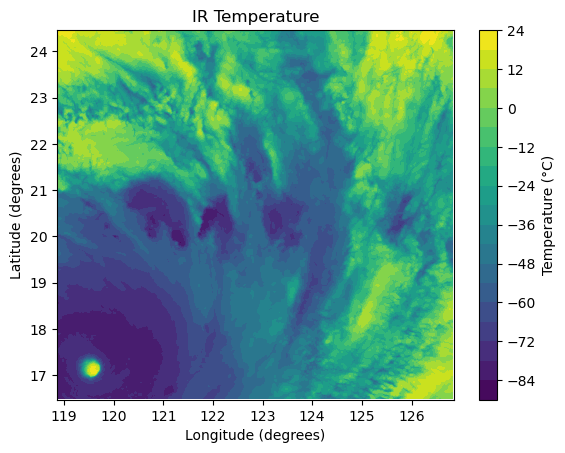

Done!
Done!


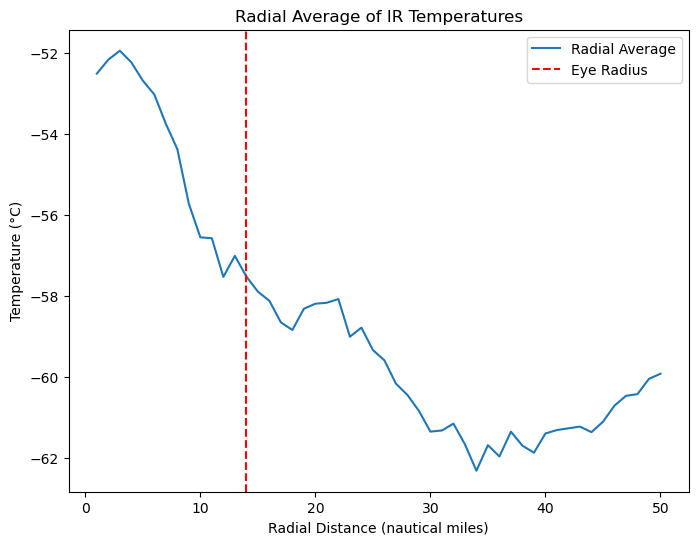

Done!
-57.40384571049823
-57.51151403594003
14.0
Done!


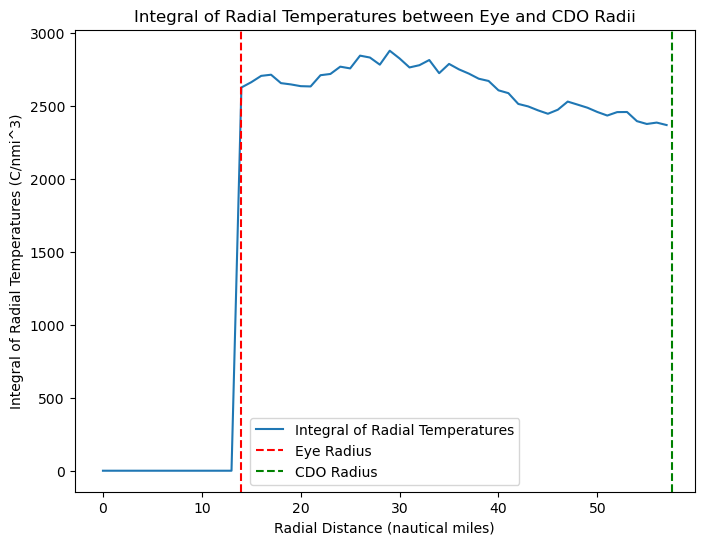

Done!
Done!
19.0
Done!


In [53]:
latitude, longitude, temps_grid_wvu, temps_grid_wvl, temps_grid_wvm, temps_grid_IR = reproject(C, Lat, Lon, Satellite)
IRC_temp, IR_temp, WVLC_temp, WVMC_temp, WVUC_temp = CenterTempCollection(temps_grid_IR, temps_grid_wvl, temps_grid_wvm, temps_grid_wvu, Lat, Lon)
cdo_temp, CDOIRDiff = CDO_temp(temps_grid_IR, Lat, Lon, latitude, longitude, IRC_temp)
eye_diameter = EyeDiameter(temps_grid_IR, Lat, Lon, latitude, longitude, IR_temp, cdo_temp)
cdo_diameter, cdo_sym, eyediam_CDOsize = CDOSymmetry(temps_grid_IR, Lat, Lon, latitude, longitude, eye_diameter)
cdo_depth, volume, integral_values, distances_smoothed1 = CDODepth(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_diameter, eye_diameter, cdo_sym)
eye_symmetry = EyeSymmetry(temps_grid_IR, Lat, Lon, latitude, longitude, eye_diameter, IRC_temp)
coldring_eye_diff, coldest_temp_distance = ColdRingDiff(temps_grid_IR, Lat, Lon, latitude, longitude, eye_diameter, cdo_diameter, cdo_sym, eyediam_CDOsize)

In [54]:
your_data = pd.read_csv('SBIA4.csv')

# Select the relevant variables
X = your_data[['Lat', 'IR Eye', 'LLWV', 'MLWV', 'ULWV', 
               'CDO Diam', 'Eye Diam', 'Eye Diam/CDO', 'Symmetry',  'CDO Temp', 'CDO Volume', 'CDO - Eye', 'Eye Symmetry', 'Normalized Cold Ring', 'Volume/Symmetry']]
y = your_data['Pressure Deficit']  # Assuming 'Pressure Deficit' is your target variable

# Split the data into training and test sets (60% training, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=47684)

# Train a random forest regression model
forest_model = RandomForestRegressor(n_estimators=50000, random_state=75456)
forest_model.fit(X_train, y_train)

# Predict on the test set
predictions1 = forest_model.predict(X_test)

# Calculate RMSE on test data
rmse_test = np.sqrt(mean_squared_error(y_test, predictions1))
print(f'RMSE on test data: {rmse_test}')

mae_test = mean_absolute_error(y_test, predictions1)
print(f'MAE on test data: {mae_test}')

# Calculate R^2 score on test data
r2_test = r2_score(y_test, predictions1)
print(f'R^2 score on test data: {r2_test}')

# Get feature importances
feature_importances = forest_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

print("Feature Importance:")
print(feature_importance_df)

RMSE on test data: 6.715458049887588
MAE on test data: 5.419778571428572
R^2 score on test data: 0.7506182751190384
Feature Importance:
                 Feature  Importance
10            CDO Volume    0.013486
5               CDO Diam    0.014875
1                 IR Eye    0.016189
6               Eye Diam    0.020581
7           Eye Diam/CDO    0.023510
14       Volume/Symmetry    0.028594
12          Eye Symmetry    0.030486
3                   MLWV    0.031567
9               CDO Temp    0.034623
2                   LLWV    0.090441
4                   ULWV    0.097111
13  Normalized Cold Ring    0.113638
0                    Lat    0.130031
8               Symmetry    0.172440
11             CDO - Eye    0.182427


In [55]:
# Make a cool plot
def mikewv():
    newcmp = LinearSegmentedColormap.from_list("", [
    (0/90, "#cece55"),
    (10/90, "#ce5555"),
    (20/90, "#262626"),
    (35/90, "#ffffff"),
    (45/90, "#55cece"),
    (60/90, "#5555ce"),
    (70/90, "#4d3366"),
    (80/90, "#e673e6"),
    (90/90, "#efe6eb")])

    vmax = 0
    vmin = -90

    return newcmp.reversed(), vmax, vmin

def mikeir():
    newcmp = LinearSegmentedColormap.from_list("", [
    (0.0, "#000000"), 
    (59.5/130, "#fefbfd"),
    (60/130, "#02fdfe"),
    (70/130, "#000171"),
    (80/130, "#00ff02"),
    (90/130, "#fdff00"),
    (100/130, "#ff0103"),
    (110/130, "#000000"),
    (119.5/130, "#e2e7e6"),
    (120/130, "#ec70c0"),
    (130/130, "#7c027f")])

    vmax = 40
    vmin = -90

    return newcmp.reversed(), vmax, vmin

# Plot the IR and WVM data side by side
fig, axes = plt.subplots(2, 2, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot IR data
im1 = axes[0, 0].contourf(longitude, latitude, temps_grid_IR, cmap=mikeir()[0], levels=np.linspace(-90, 40, 1000), vmax=40, vmin=-90)
plt.colorbar(im1, ax=axes[0, 0], label='Temperature (°C)', pad=0.05, aspect=40)
axes[0, 0].set_title(f'Band 13 Temperature GOES-R ({StormID} {Year})')
axes[0, 0].set_xlabel('Longitude (degrees)')
axes[0, 0].set_ylabel('Latitude (degrees)')
circle_cdo = plt.Circle((Lon, Lat), (cdo_diameter / 2)/60, color='red', fill=False, linestyle='--', label='CDO Diameter')
circle_eye = plt.Circle((Lon, Lat), (eye_diameter / 2)/60, color='gold', fill=False, linestyle='--', label='Eye Diameter')
circle_cold = plt.Circle((Lon, Lat), coldest_temp_distance/60, color='pink', fill=False, linestyle=':', label='Cold Ring')
axes[0, 0].add_patch(circle_cdo)
axes[0, 0].add_patch(circle_eye)
axes[0, 0].add_patch(circle_cold)
axes[0, 0].scatter([Lon], [Lat], color='yellow', marker='x', label='Location')
axes[0, 0].legend()

# Add country and state borders
axes[0, 0].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axes[0, 0].add_feature(cfeature.STATES, linestyle='-', edgecolor='black')
axes[0, 0].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')


# Plot WVM data
im2 = axes[0, 1].contourf(longitude, latitude, temps_grid_wvm, cmap=mikewv()[0], levels=np.linspace(-90, 0, 1000), vmax=0, vmin=-90)
plt.colorbar(im2, ax=axes[0, 1], label='Temperature (°C)', pad=0.05, aspect=40)
axes[0, 1].set_title(f'Band 9 Temperature GOES-R ({StormID} {Year})')
axes[0, 1].set_xlabel('Longitude (degrees)')
axes[0, 1].set_ylabel('Latitude (degrees)') 
circle_cdo = plt.Circle((Lon, Lat), (cdo_diameter / 2)/60, color='red', fill=False, linestyle='--', label='CDO Diameter')
circle_eye = plt.Circle((Lon, Lat), (eye_diameter / 2)/60, color='gold', fill=False, linestyle='--', label='Eye Diameter')
circle_cold = plt.Circle((Lon, Lat), coldest_temp_distance/60, color='pink', fill=False, linestyle=':', label='Cold Ring')
axes[0, 1].add_patch(circle_cdo)
axes[0, 1].add_patch(circle_eye)
axes[0, 1].add_patch(circle_cold)
axes[0, 1].scatter([Lon], [Lat], color='yellow', marker='x', label='Location')
axes[0, 1].legend()

# Add country and state borders
axes[0, 1].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axes[0, 1].add_feature(cfeature.STATES, linestyle='-', edgecolor='black')
axes[0, 1].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')


# Print statements in 1,0 subplot
axes[1, 0].text(0.025, 0.95, f'Latitude: {Lat:.2f}, Longitude: {Lon:.2f}', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.88, f'IR Eye Temp: {IRC_temp:.2f}°C', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.81, f'Low-Level WV Eye Temp: {WVLC_temp:.2f}°C', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.74, f'Mid-Level WV Eye Temp: {WVMC_temp:.2f}°C', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.67, f'Upper-Level WV Eye Temp: {WVUC_temp:.2f}°C', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.60, f'CDO Diameter: {cdo_diameter:.2f} nmi', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.53, f'Eye Diameter: {eye_diameter:.2f} nmi', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.46, f'Eye Diameter/CDO Diameter Ratio: {eyediam_CDOsize:.2f}', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.39, f'CDO Symmetry: {cdo_sym:.2f}', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.32, f'CDO Thickness: {cdo_depth:.2f} Σ°C/nmi', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.25, f'CDO Temperature: {cdo_temp:.2f}°C', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.18, f'CDO/Eye Temperature Differential: {CDOIRDiff:.2f}°C', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.11, f'Eye Symmetry: {eye_symmetry:.2f}', transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].text(0.025, 0.04, f'Standardized Cold Ring/Eye Radius Differential Score: {coldring_eye_diff:.2f}', transform=axes[1, 0].transAxes, fontsize=14)



# Predict pressure deficit
prediction = forest_model.predict([[Lat, IRC_temp, WVLC_temp, WVMC_temp, WVUC_temp,
                                cdo_diameter, eye_diameter, eyediam_CDOsize, cdo_sym,
                                cdo_temp, cdo_depth, CDOIRDiff, eye_symmetry, coldring_eye_diff, volume]])
fig.text(0.5, 0.45, f'Pressure Deficit: {prediction[0]} hPa', ha='center', fontsize=12)

prediction = prediction[0]

plt.tight_layout()
plt.savefig('GOES-R_IR_WVM_Temperature.png')
plt.close()

/usr/licensed/anaconda3/2024.2/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [56]:
# Create a new figure
plt.figure(figsize=(12, 10))

# Histogram of pressure deficits in SBIA4
plt.hist(y, bins=50, density=True, alpha=0.6, color='g', label='Pressure Deficits')

# Calculate mean and standard deviation of pressure deficits
mean, std = np.mean(y), np.std(y)

# Generate range of values for the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

# Calculate percentile of the current deficit estimate
percentile = norm.cdf(prediction, mean, std) * 100

# Add a line at the percentile of the current deficit estimate
plt.axvline(prediction, color='r', linestyle='--', label=f'Current Storm Deficit Estimate (Percentile: {percentile:.2f}%)')

# Add labels and legend
plt.title('Pressure Deficits Distribution (n = 150, Recon-Obseved Datapoints during 2018-2023 in North Atlantic Basin ONLY)')
plt.xlabel('Pressure Deficit (hPa)')
plt.ylabel('Density')
plt.legend()

# Add text below the legend
plt.text(0.5, -0.1, f'RMSE: {rmse_test:.2f} hPa, MAE: {mae_test:.2f} hPa, R^2: {r2_test * 100:.2f} %', 
         transform=plt.gca().transAxes, horizontalalignment='center', fontsize=10)

# Save the plot to a PNG file
plt.tight_layout()
plt.savefig('pressure_deficits_distribution.png')
plt.close()